<a href="https://colab.research.google.com/github/jhhan0/self-study-ml/blob/main/tutorials/generative/neural-style-transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

- Demonstrates a simple application of style transfer with a pretrained model from TensorFlow Hub.
- Full tutorial reference: https://www.tensorflow.org/tutorials/generative/style_transfer (Fast Style Transfer using TF-Hub)

In [3]:
import os
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [4]:
# load compressed model
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
# customize matplotlib's runtime configuration settings
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12, 12)

Download content and style reference images.

In [5]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

195196/195196 [==============================] - 0s 0us/step


Before demonstrating style transfer algorithm, visualize both content images and style reference images.

In [6]:
# define a function to load an image and limit its dimention to 512 pixels
def load_image(path_to_image):
  max_dim = 512
  img = tf.io.read_file(path_to_image)
  img = tf.image.decode_image(img, channels=3, dtype=tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], dtype=tf.float32)
  scale = max_dim / max(shape)
  new_shape = tf.cast(shape*scale, tf.int32)

  img = tf.image.resize(images=img, size=new_shape)
  # for 1 batch size
  img = img[tf.newaxis, :]
  return img

In [7]:
def display_image(image, title=None):
  # shrink image size from (batch_size, height, width, channels) -> (height, width, channels)
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    plt.axis('off')

  if title:
    plt.title(title)

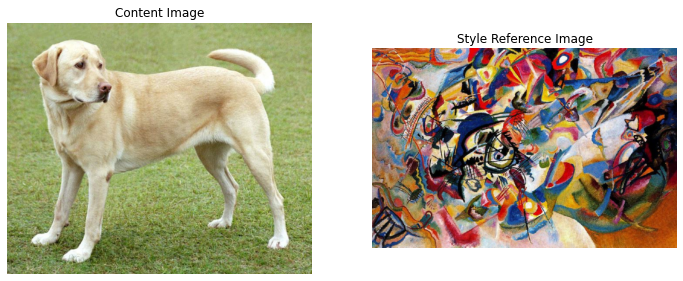

In [8]:
plt.subplot(1, 2, 1)
content = load_image(content_path)
display_image(content, "Content Image")

plt.subplot(1, 2, 2)
style = load_image(style_path)
display_image(style, "Style Reference Image")

## Fast Style Transfer using TensorFlow Hub Model

Since the result of style transfer TensorFlow Hub Model is a list of tensor of shape (batch_size, height, width, channels), a function ```tensor2image``` is required.

In [9]:
def tensor2image(tensor):
  # np.uint8 has range of [0, 255] which covers full pixel value range
  tensor = np.array(tensor*255, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    # if batch_size == 1
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  # create an image from a given object (tensor)
  return PIL.Image.fromarray(tensor)

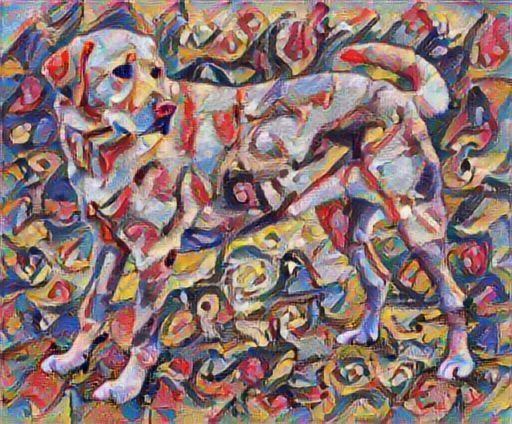

In [10]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
# get a transferred image from a list of result(s)
transferred_image = hub_model(tf.constant(content), tf.constant(style))[0]
tensor2image(transferred_image)

- Step-by-step tutorial on how to transfer the style of a reference image to target image using gradient descent.
- Full tutorial reference: https://keras.io/examples/generative/neural_style_transfer/

In [11]:
content_path = tf.keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_path = tf.keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")

935806/935806 [==============================] - 0s 0us/step


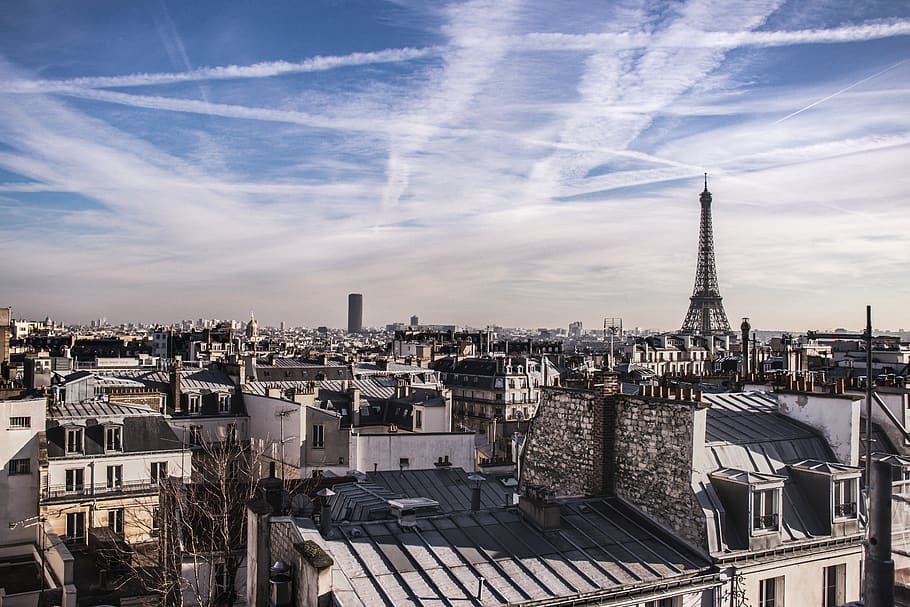

In [12]:
# content image
display(Image(content_path))

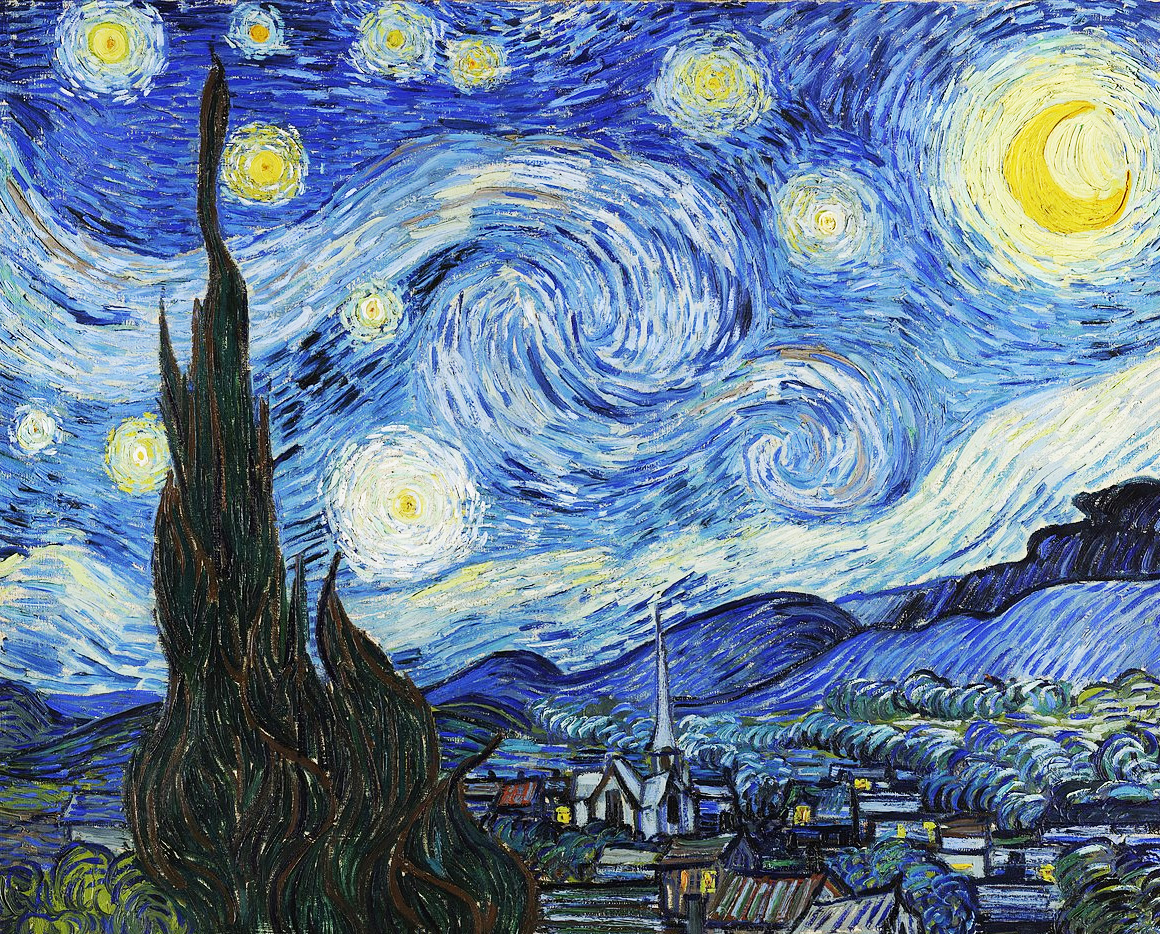

In [13]:
# reference style image
display(Image(style_path))

In [21]:
# define weights of the different losses
content_weight = 2.5e-8
style_weight = 1e-6
total_variation_weight = 1e-6

# dimensions of the generated image
width, height = tf.keras.preprocessing.image.load_img(content_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

Define two functions to preprocess and deprocess images.

In [15]:
def preprocess_image(path):
  # load an image with target_size
  img = tf.keras.preprocessing.image.load_img(path, target_size=(img_nrows, img_ncols))
  img = tf.keras.preprocessing.image.img_to_array(img)
  # add an 'outer' batch dimension
  img = tf.expand_dims(img, axis=0)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return tf.convert_to_tensor(img)

# convert a tensor into a valid image
def deprocess_image(tensor):
  img = tensor.reshape((img_nrows, img_ncols, 3))
  # remove zero-center by adding each channel's mean pixel value of ImageNet Dataset
  imagenet_mean_values = [103.939, 116.779, 123.68]
  for i in range(len(imagenet_mean_values)):
    img[:,:,i] += imagenet_mean_values[i]
  # change 'BGR' -> 'RGB'
  img = img[:, :, ::-1]
  img = np.clip(img, 0, 255).astype("uint8")
  return img

Compute the style transfer loss by defining four utility functions:
- ```gram_matrix``` that is used to compute the *style loss*.
- ```style_loss``` which keeps the generated image close to the local textures of the style reference image.
- ```content_loss``` which keeps the high-level representation of the generated image close to that of the content image.
- ```total_variation_loss``` which keeps the generated image locally-coherent.

Reference from https://keras.io/examples/generative/neural_style_transfer/#compute-the-style-transfer-loss

In [25]:
def gram_matrix(x):
  x = tf.transpose(x, [2, 0, 1])
  # if one component of shape is the special value -1, the size of that dimension is computed so that the total size remains constant
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  # feature-wise outer product
  gram = tf.matmul(features, tf.transpose(features))
  return gram

def style_loss(style, combination):
  style = gram_matrix(style)
  combination = gram_matrix(combination)
  channels = 3
  size = img_nrows * img_ncols
  return tf.reduce_sum(tf.square(style - combination)) / (4.0 * (channels**2) * (size**2))

def content_loss(content, combination):
  return tf.reduce_sum(tf.square(combination - content))

def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

Create a feature extraction model.

In [20]:
model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs = dict([(layer.name, layer.output) for layer in model.layers])
# returns the activation values for every layer in VGG19
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs)

Compute the style transfer loss.

In [35]:
# a list of layers to use for the style loss
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# a layer to use for the content loss
content_layer_name = "block5_conv2"


def compute_loss(content, style, combination):
    input_tensor = tf.concat([content, style, combination], axis=0)
    features = feature_extractor(input_tensor)

    # initialize the loss
    loss = tf.zeros(shape=())

    # add content loss
    layer_features = features[content_layer_name]
    content_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(content_features, combination_features)

    # add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # add total variation loss
    loss += total_variation_weight * total_variation_loss(combination)
    return loss

In [23]:
@tf.function
def compute_loss_and_grads(content, style, combination):
    with tf.GradientTape() as tape:
        loss = compute_loss(content, style, combination)
    grads = tape.gradient(loss, combination)
    return loss, grads

Train the model by repeatedly running gradient descent iteration steps to minimize the loss.

In [26]:
optimizer = tf.keras.optimizers.SGD(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

content = preprocess_image(content_path)
style = preprocess_image(style_path)
combination = tf.Variable(preprocess_image(content_path))

iterations = 5000
for i in range(1, iterations+1):
  loss, grads = compute_loss_and_grads(content, style, combination)
  optimizer.apply_gradients([(grads, combination)])
  if i % 100 == 0:
    print("Iteration %d: loss=%.2f" % (i, loss))
    img = deprocess_image(combination.numpy())

Iteration 100: loss=11018.30
Iteration 200: loss=8514.25
Iteration 300: loss=7571.79
Iteration 400: loss=7064.10
Iteration 500: loss=6736.23
Iteration 600: loss=6501.66
Iteration 700: loss=6323.09
Iteration 800: loss=6181.40
Iteration 900: loss=6065.28
Iteration 1000: loss=5967.67
Iteration 1100: loss=5884.49
Iteration 1200: loss=5812.77
Iteration 1300: loss=5750.40
Iteration 1400: loss=5695.67
Iteration 1500: loss=5647.28
Iteration 1600: loss=5604.19
Iteration 1700: loss=5565.55
Iteration 1800: loss=5530.73
Iteration 1900: loss=5499.17
Iteration 2000: loss=5470.52
Iteration 2100: loss=5444.45
Iteration 2200: loss=5420.55
Iteration 2300: loss=5398.61
Iteration 2400: loss=5378.41
Iteration 2500: loss=5359.74
Iteration 2600: loss=5342.52
Iteration 2700: loss=5326.57
Iteration 2800: loss=5311.76
Iteration 2900: loss=5298.00
Iteration 3000: loss=5285.19
Iteration 3100: loss=5273.21
Iteration 3200: loss=5262.02
Iteration 3300: loss=5251.55
Iteration 3400: loss=5241.74
Iteration 3500: loss=5

In [33]:
tf.keras.preprocessing.image.save_img("paris_generated.png", deprocess_image(combination.numpy()))

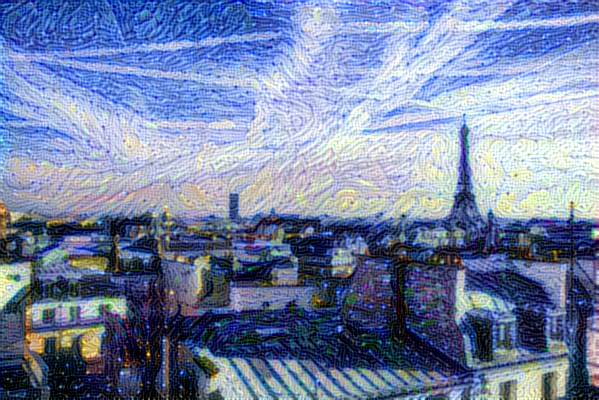

In [34]:
display(Image("paris_generated.png"))

Author: [fchollet](https://twitter.com/fchollet)
Date created: 2016/01/11
Last modified: 2020/05/02